In [18]:
import os
import sys
sys.path.insert(0, "../Uformer-RSBlur")
from ISP.utils import *

import glob
import rawpy
import cv2
import torch
import matplotlib.pyplot as plt
import random



# 시각화 코드
def viz_two_images(img1, img2, title1, title2):
    fig = plt.figure(figsize=(16, 16))
    rows = 1; cols = 2

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.set_title(title1)
    
    if len(img1.shape) == 2:
        image1 = ax1.imshow(img1, 'gray')
    else:
        image1 = ax1.imshow(img1)

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.set_title(title2)
    
    if len(img2.shape) == 2:
        image2 = ax2.imshow(img2, 'gray')
    else:
        image2 = ax2.imshow(img2)
    fig.tight_layout()
    plt.show()
demosaic = Demosaic()

샘플로 블러 이미지 한장에 해당하는 sharp images들을 미리 프레임 인터폴레이션을 수행해 놓았습니다. 원래는 7 프레임으로 구성되어져 있었지만 x8 프레임 인터폴레이션을 수행하여 총 49장 (프레임 사이 7장 보간 * 6 + 원래 프레임 7장) 을 저장해놓았습니다.

In [359]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR).astype('float32')/255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

imgs_path = glob.glob('samples/000002/*.png')
imgs_list = [load_img(path) for path in imgs_path] # read interpolated frames

len(imgs_list)

49

# Synthetic blur (Avg)

프레임 보간 하기전의 원래 프레임인 7장 만을 평균 합니다. 

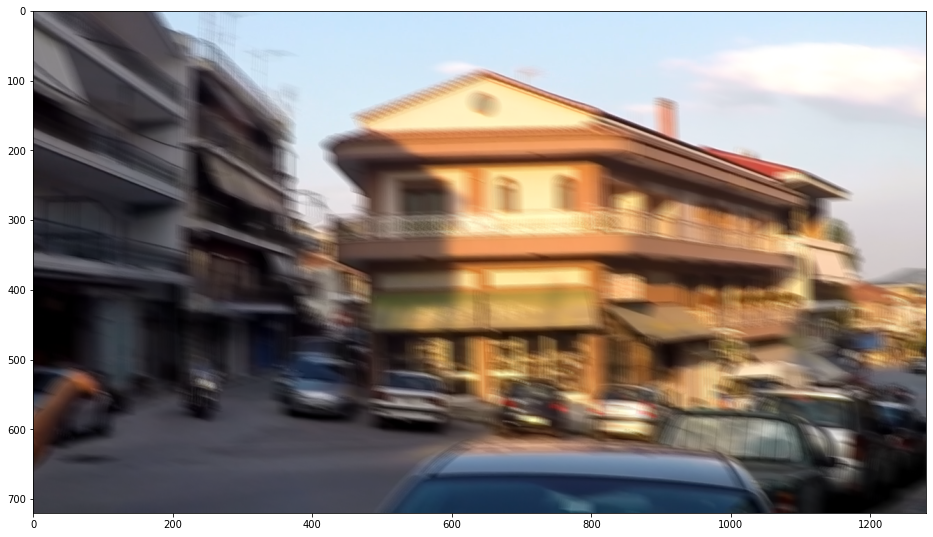

In [361]:
imgs = torch.from_numpy(np.array([img for i, img in enumerate(imgs_list) if i % 8 == 0])) # original 7 frames
avg_imgs = torch.mean(imgs, dim=0)

plt.figure(figsize=(16, 16))
plt.imshow(avg_imgs)

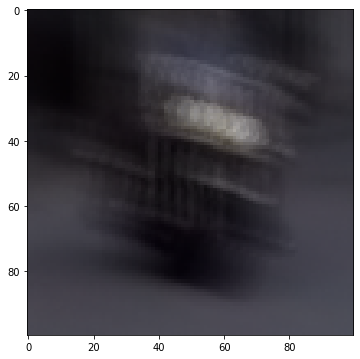

In [364]:
plt.figure(figsize=(6, 6))
plt.imshow(avg_imgs[500:600, 190:290, :])

프레임 사이의 temporal gap 때문에 불연속 적인 블러가 생성 됩니다.

# Synthetic blur (Interpolation + Avg)

프레임 인터폴레이션을 사용 하면, 보다 연속적인 블러를 생성 할 수 있습니다.

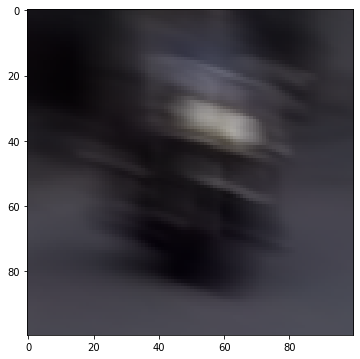

In [290]:
imgs = torch.from_numpy(np.array(imgs_list)) # original 7 frames
avg_imgs = torch.mean(imgs, dim=0)

plt.figure(figsize=(6, 6))
plt.imshow(avg_imgs[500:600, 190:290, :])

# Synthetic blur (Interpolation + sRGB2Lin & Avg)

선형 공간에서 블러가 생기는 것을 모사하기 위해 sRGB 영상들을 inverse CRF를 통해 Linear RGB로 변환합니다. GoPro 데이터셋의 경우 gamma decoding이 CRF로 알려져 있습니다.

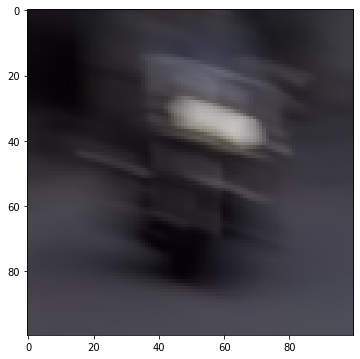

In [391]:
imgs = torch.from_numpy(np.array(imgs_list)) # original 7 frames

imgs = rgb2lin_pt(imgs) # gamma decoding
avg_imgs = torch.mean(imgs, dim=0)

plt.figure(figsize=(6, 6))
plt.imshow(lin2rgb_pt(avg_imgs)[500:600, 190:290, :])

# Synthetic blur (Interpolation + sRGB2Lin & Avg + Saturation)

Averaging 이미지와 saturation mask를 계산합니다.

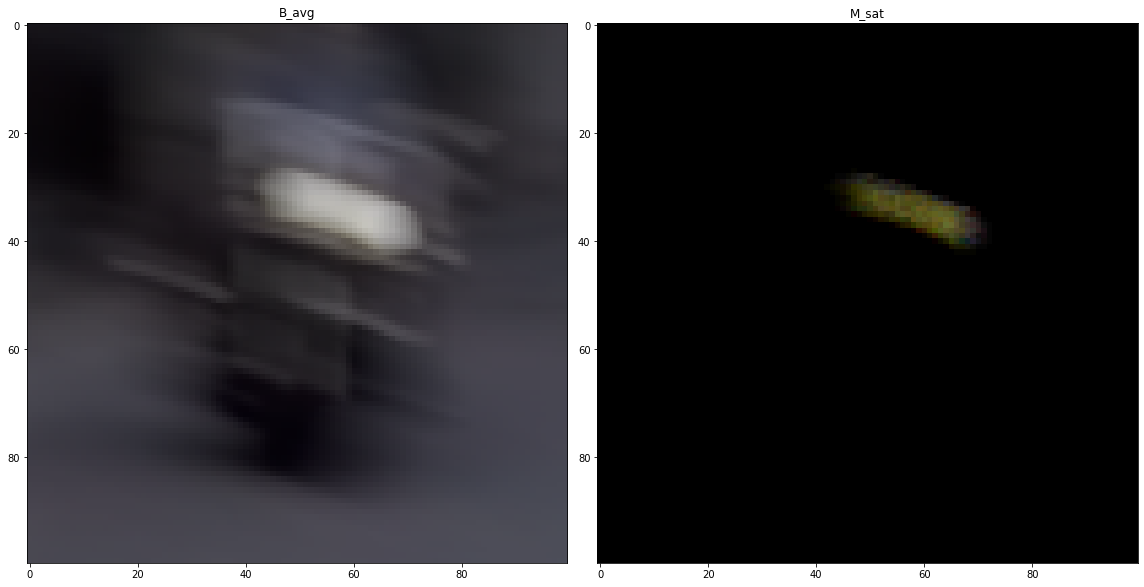

In [365]:
imgs = torch.from_numpy(np.array(imgs_list)) # original 7 frames
imgs = rgb2lin_pt(imgs)
avg_img = torch.mean(imgs, dim=0)

mask_imgs = (imgs == 1).float()
sat_mask = torch.mean(mask_imgs, dim=0)

viz_two_images(lin2rgb_pt(avg_img[500:600, 190:290, :]), sat_mask[500:600, 190:290, :], 'B_avg', 'M_sat')

sacling factor를 랜덤하게 샘플링하고, 이를 곱하여 saturated pixels을 생성합니다.


1.5305108829032408


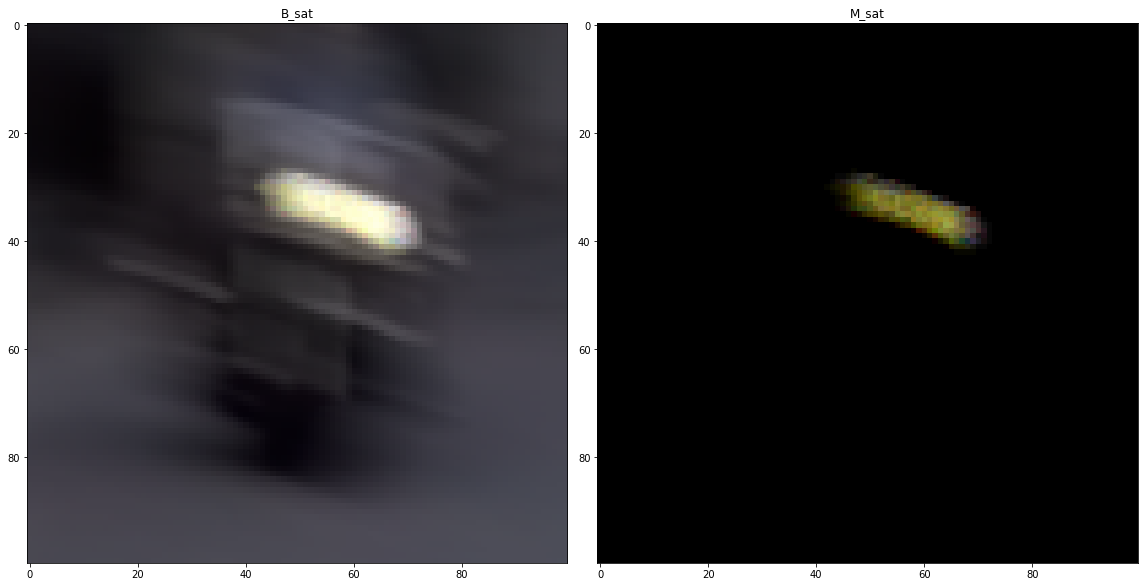

In [381]:
# local scaling
scale_saturation = random.uniform(0.25, 1.75) # 3
print(scale_saturation)
sat_avg_img = avg_img + (sat_mask * scale_saturation)
sat_avg_img = torch.clamp(sat_avg_img, 0, 1)

# linear sRGB to sRGB
srgb_avg_imgs = lin2rgb_pt(sat_avg_img)

viz_two_images(srgb_avg_imgs[500:600, 190:290, :], sat_mask[500:600, 190:290, :] * scale_saturation, 'B_sat', 'M_sat')


```python

class SyntheticBlurredDataset(Dataset):
    def __init__(self, image_dir):
        ...
        ...
        ...

    def __getitem__(self, idx):
        
        # load a avg image, a mask image
        avg_img = torch.from_numpy(load_img(avg_img_path))
        sat_mask = torch.from_numpy(load_img(sat_mask_path))
        
        # local scaling
        scale_saturation = random.uniform(0, 3) # 3
        avg_img = avg_img + (sat_mask * scale_saturation)
        avg_img = torch.clamp(avg_img, 0, 1)

        # linear sRGB to sRGB
        srgb_avg_imgs = lin2rgb_pt(avg_imgs)


```

# Synthetic blur (Interpolation + sRGB2Lin & Avg + Saturation +  Realistic Noise)

In [85]:
demosaic = Demosaic()

1.4675670815505582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


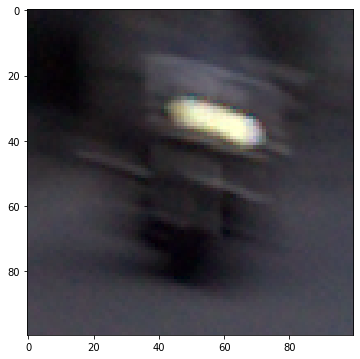

In [386]:
# local scaling
scale_saturation = random.uniform(0.25, 1.75) # 3
print(scale_saturation)
sat_avg_img = avg_img + (sat_mask * scale_saturation)
sat_avg_img = torch.clamp(sat_avg_img, 0, 1)

# from linear RGB to XYZ
img_XYZ = lin2xyz(sat_avg_img)  # XYZ

# from XYZ to Cam
img_Cam = apply_cmatrix(img_XYZ, xyz2cam_realblur)  # raw RGB

# Mosaic
bayer_pattern = random.choice(['RGGB', 'BGGR', 'GRBG', 'GBRG'])
img_mosaic = mosaic_bayer(img_Cam, bayer_pattern)

# inverse white balance
red_gain = random.uniform(1.9, 2.4)
blue_gain = random.uniform(1.5, 1.9)
img_mosaic = WB_img(img_mosaic, bayer_pattern, 1 / red_gain, 1 / blue_gain)

# -------- ADDING POISSON-GAUSSIAN NOISE ON RAW -
# estimated noise for the RealBlur dataset
beta1 = 8.8915e-05
beta2 = 2.9430e-05

img_mosaic_noise = add_Poisson_noise_random(img_mosaic, beta1, beta2)

# -------- ISP PROCESS --------------------------
# White balance
img_demosaic = WB_img(img_mosaic_noise, bayer_pattern, red_gain, blue_gain)

# demosaic
img_demosaic = torch.nn.functional.pixel_shuffle(img_demosaic.permute(2, 0, 1).unsqueeze(0), 2)
img_demosaic = demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)

# from Cam to XYZ
img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

# frome XYZ to linear RGB
img_IL = xyz2lin(img_IXYZ)


plt.figure(figsize=(6, 6))
plt.imshow(lin2rgb_pt(img_IL)[500:600, 190:290, :])

# Adopt CRF of A7R3

gamma encoding 대신 A7R3 카메라에서 추정 된 CRF 를 적용합니다.

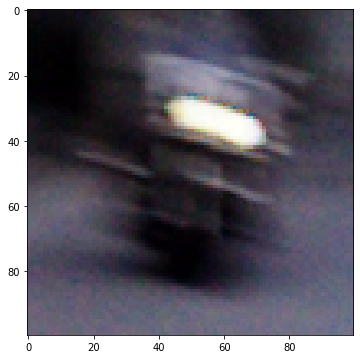

In [387]:
a7r3_srgb_avg_imgs = lin2rgb_a7r3_polynomial(img_IL)
a7r3_srgb_avg_imgs = torch.clamp(a7r3_srgb_avg_imgs, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(a7r3_srgb_avg_imgs[500:600, 190:290, :])

# Full pipeline


1.6554070771878044


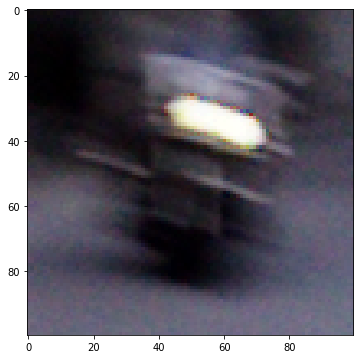

In [403]:
# Interpolation
imgs = torch.from_numpy(np.array(imgs_list)) # 49 frames

# sRGB2Lin
imgs = rgb2lin_pt(imgs)

# Averaging
avg_img = torch.mean(imgs, dim=0)

mask_imgs = (imgs == 1).float()
sat_mask = torch.mean(mask_imgs, dim=0)

# Saturation synthesis
scale_saturation = random.uniform(0.25, 1.75)
print(scale_saturation)
sat_avg_img = avg_img + (sat_mask * scale_saturation)
sat_avg_img = torch.clamp(sat_avg_img, 0, 1)

# from linear RGB to XYZ
img_XYZ = lin2xyz(sat_avg_img)  # XYZ

# from XYZ to Cam
img_Cam = apply_cmatrix(img_XYZ, xyz2cam_realblur)  # raw RGB

# Mosaic
bayer_pattern = random.choice(['RGGB', 'BGGR', 'GRBG', 'GBRG'])
img_mosaic = mosaic_bayer(img_Cam, bayer_pattern)

# inverse white balance
red_gain = random.uniform(1.9, 2.4)
blue_gain = random.uniform(1.5, 1.9)
img_mosaic = WB_img(img_mosaic, bayer_pattern, 1 / red_gain, 1 / blue_gain)

# -------- ADDING POISSON-GAUSSIAN NOISE ON RAW -
# estimated noise for the RealBlur dataset
beta1 = 8.8915e-05
beta2 = 2.9430e-05

img_mosaic_noise = add_Poisson_noise_random(img_mosaic, beta1, beta2)

# -------- ISP PROCESS --------------------------
# White balance
img_demosaic = WB_img(img_mosaic_noise, bayer_pattern, red_gain, blue_gain)

# demosaic
img_demosaic = torch.nn.functional.pixel_shuffle(img_demosaic.permute(2, 0, 1).unsqueeze(0), 2)
img_demosaic = demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)

# from Cam to XYZ
img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

# frome XYZ to linear RGB
img_IL = xyz2lin(img_IXYZ)

# Adopt CRF of A7R3
a7r3_srgb_avg_imgs = lin2rgb_a7r3_polynomial(img_IL)
a7r3_srgb_avg_imgs = torch.clamp(a7r3_srgb_avg_imgs, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(a7r3_srgb_avg_imgs[500:600, 190:290, :])

In [34]:
import os
import sys
sys.path.insert(0, "../Uformer-RSBlur")
from ISP.utils import *

from torch.utils.data import Dataset
import glob
import os
import cv2

class RealisticGoProABMEDataset(Dataset):
    def __init__(self, image_dir, patch_size=256, image_aug=True, realistic_pipeline=True):
        self.image_dir = image_dir
        self.image_list = glob.glob(os.path.join(image_dir, '**/**/avg_inter_img/*.png'))
        self._check_image(self.image_list)
        self.image_list.sort()
        self.ps = patch_size
        self.realistic_pipeline = realistic_pipeline

        self.image_aug = image_aug
        self.demosaic = Demosaic()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        # read a sharp image
        label = cv2.imread(self.image_list[idx].replace('/avg_inter_img/avg_blur.png', '/gt/gt_sharp.png'),
                           cv2.IMREAD_COLOR).astype('float32') / 255
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        blurred = cv2.imread(self.image_list[idx], cv2.IMREAD_COLOR).astype('float32') / 255
        blurred = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)

        sat_mask = cv2.imread(self.image_list[idx].replace('/avg_inter_img/', '/avg_inter_mask_100/'),
                              cv2.IMREAD_COLOR).astype('float32') / 255
        sat_mask = cv2.cvtColor(sat_mask, cv2.COLOR_BGR2RGB)

        # numpy to torch
        label_pt = torch.from_numpy(label).float()
        blurred_pt = torch.from_numpy(blurred).float()
        sat_mask_pt = torch.from_numpy(sat_mask).float()

        # random crop
        boundary_size = 8
        ps = self.ps + boundary_size
        hh, ww = label_pt.shape[0], label_pt.shape[1]

        rr = random.randint(0, hh - ps)
        cc = random.randint(0, ww - ps)

        label_pt = label_pt[rr:rr + ps, cc:cc + ps, :]
        blurred_pt = blurred_pt[rr:rr + ps, cc:cc + ps, :]
        sat_mask_pt = sat_mask_pt[rr:rr + ps, cc:cc + ps, :]

        # random image augmentation
        if self.image_aug:
            aug = random.randint(0, 8)
            if aug == 1:
                label_pt = label_pt.flip(0)
            elif aug == 2:
                label_pt = label_pt.flip(1)
            elif aug == 3:
                label_pt = torch.rot90(label_pt, dims=(0, 1))
            elif aug == 4:
                label_pt = torch.rot90(label_pt, dims=(0, 1), k=2)
            elif aug == 5:
                label_pt = torch.rot90(label_pt, dims=(0, 1), k=3)
            elif aug == 6:
                label_pt = torch.rot90(label_pt.flip(0), dims=(0, 1))
            elif aug == 7:
                label_pt = torch.rot90(label_pt.flip(1), dims=(0, 1))

            if aug == 1:
                blurred_pt = blurred_pt.flip(0)
            elif aug == 2:
                blurred_pt = blurred_pt.flip(1)
            elif aug == 3:
                blurred_pt = torch.rot90(blurred_pt, dims=(0, 1))
            elif aug == 4:
                blurred_pt = torch.rot90(blurred_pt, dims=(0, 1), k=2)
            elif aug == 5:
                blurred_pt = torch.rot90(blurred_pt, dims=(0, 1), k=3)
            elif aug == 6:
                blurred_pt = torch.rot90(blurred_pt.flip(0), dims=(0, 1))
            elif aug == 7:
                blurred_pt = torch.rot90(blurred_pt.flip(1), dims=(0, 1))

            if aug == 1:
                sat_mask_pt = sat_mask_pt.flip(0)
            elif aug == 2:
                sat_mask_pt = sat_mask_pt.flip(1)
            elif aug == 3:
                sat_mask_pt = torch.rot90(sat_mask_pt, dims=(0, 1))
            elif aug == 4:
                sat_mask_pt = torch.rot90(sat_mask_pt, dims=(0, 1), k=2)
            elif aug == 5:
                sat_mask_pt = torch.rot90(sat_mask_pt, dims=(0, 1), k=3)
            elif aug == 6:
                sat_mask_pt = torch.rot90(sat_mask_pt.flip(0), dims=(0, 1))
            elif aug == 7:
                sat_mask_pt = torch.rot90(sat_mask_pt.flip(1), dims=(0, 1))

        if not self.realistic_pipeline:
            blurred = blurred_pt
            gt = label_pt

            # crop boundary of blurred images
            blurred = blurred[boundary_size // 2:-boundary_size // 2, boundary_size // 2:-boundary_size // 2, :]
            gt = gt[boundary_size // 2:-boundary_size // 2, boundary_size // 2:-boundary_size // 2, :]

            # to_tensor
            blurred = blurred.permute((2, 0, 1)).contiguous()
            gt = gt.permute((2, 0, 1)).contiguous()

            return gt, blurred

        # -------- RSBlur Pipeline -----------------------
        # -------- INVERSE ISP PROCESS -------------------
        # inverse tone mapping
        blurred_L = rgb2lin_pt(blurred_pt)

        # saturation synthesis
        alpha_saturation = random.uniform(0.25, 1.75)
        blurred_L = blurred_L + (alpha_saturation * sat_mask_pt)
        blurred_L = torch.clamp(blurred_L, 0, 1)

        blurred_sat = blurred_L.clone()

        # from linear RGB to XYZ
        img_XYZ = lin2xyz(blurred_L)  # XYZ

        # from XYZ to Cam
        img_Cam = apply_cmatrix(img_XYZ, xyz2cam_realblur)  # raw RGB

        # Mosaic
        bayer_pattern = random.choice(['RGGB', 'BGGR', 'GRBG', 'GBRG'])
        img_mosaic = mosaic_bayer(img_Cam, bayer_pattern)

        # inverse white balance
        red_gain = random.uniform(1.9, 2.4)
        blue_gain = random.uniform(1.5, 1.9)
        img_mosaic = WB_img(img_mosaic, bayer_pattern, 1 / red_gain, 1 / blue_gain)

        # -------- ADDING POISSON-GAUSSIAN NOISE ON RAW -
        # estimated noise for the RealBlur dataset
        beta1 = 8.8915e-05
        beta2 = 2.9430e-05

        img_mosaic_noise = add_Poisson_noise_random(img_mosaic, beta1, beta2)

        # -------- ISP PROCESS --------------------------
        # White balance
        img_demosaic = WB_img(img_mosaic_noise, bayer_pattern, red_gain, blue_gain)

        # demosaic
        img_demosaic = torch.nn.functional.pixel_shuffle(img_demosaic.permute(2, 0, 1).unsqueeze(0), 2)
        img_demosaic = self.demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)

        # from Cam to XYZ
        img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

        # frome XYZ to linear RGB
        img_IL = xyz2lin(img_IXYZ)

        # tone mapping
        img_Irgb = lin2rgb_pt(img_IL)
        # img_Irgb = lin2rgb_a7r3_polynomial(img_IL)
        img_Irgb = torch.clamp(img_Irgb, 0, 1)  # (h, w, c)

        blurred = img_Irgb
        gt = label_pt

        # don't add noise on saturated region
        sat_region = torch.ge(blurred_sat, 1.0)
        non_sat_region = torch.logical_not(sat_region)
        blurred = (blurred_sat * sat_region) + (blurred * non_sat_region)

        # Adopt a7r3 CRF
        gt = lin2rgb_a7r3_polynomial(rgb2lin_pt(gt))
        blurred = lin2rgb_a7r3_polynomial(rgb2lin_pt(blurred))

        # crop boundary of blurred images
        blurred = blurred[boundary_size // 2:-boundary_size // 2, boundary_size // 2:-boundary_size // 2, :]
        gt = gt[boundary_size // 2:-boundary_size // 2, boundary_size // 2:-boundary_size // 2, :]

        # to_tensor
        blurred = blurred.permute((2, 0, 1)).contiguous()
        gt = gt.permute((2, 0, 1)).contiguous()

        return gt, blurred

    @staticmethod
    def _check_image(lst):
        for x in lst:
            splits = x.split('.')
            if splits[-1] not in ['png', 'jpg', 'jpeg']:
                raise ValueError

In [51]:
gopro_abme_dataset = RealisticGoProABMEDataset('../Uformer-RSBlur/datasets/GOPRO_INTER_ABME', realistic_pipeline=True)

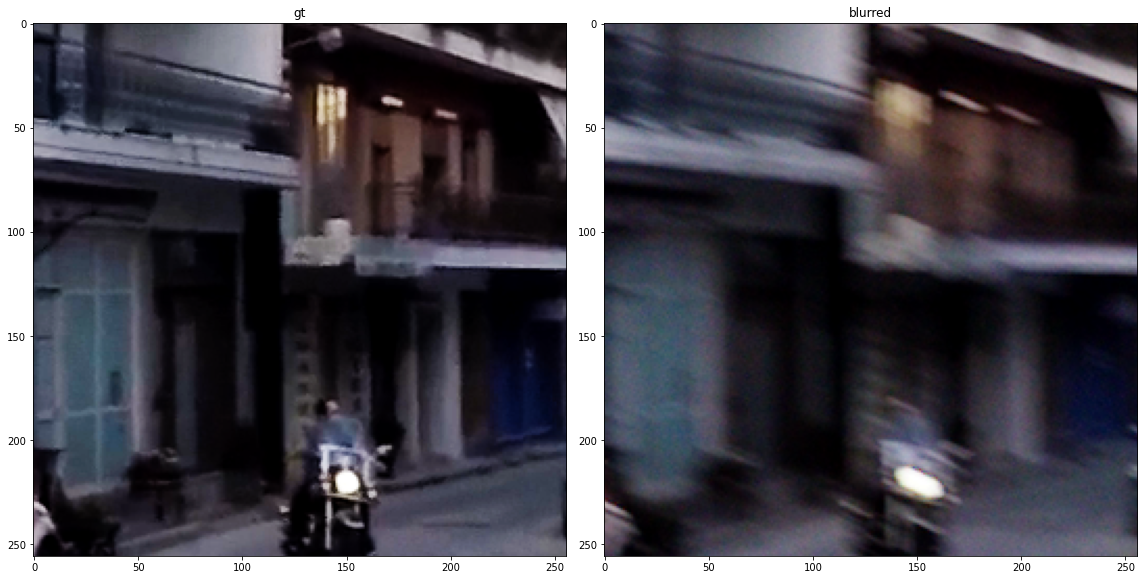

In [67]:
sample = gopro_abme_dataset[0]
viz_two_images(sample[0].permute(1, 2, 0), sample[1].permute(1, 2, 0), 'gt', 'blurred')